In [34]:
import re
import sys
import io
import numpy as np
import itertools
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

!pip install nolds
import nolds

# Synthetic Data Generation

In [35]:
def Lorentz_System(state, sigma, rho, beta):
    x, y, z = state
    x_dot = sigma*(y-x)
    y_dot = x*(rho-z) - y
    z_dot = x*y - beta*z

    return np.array([x_dot, y_dot, z_dot])

### Runga Kutta

In [36]:
def rk4(state, dt, sigma, rho, beta):
    k1 = Lorentz_System(state, sigma, rho, beta)
    k2 = Lorentz_System(state + 0.5 * dt * k1, sigma, rho, beta)
    k3 = Lorentz_System(state + 0.5 * dt * k2, sigma, rho, beta)
    k4 = Lorentz_System(state + dt * k3, sigma, rho, beta)

    return state + (dt*((k1 + 2*k2 + 2*k3 + k4)/6.0))
    

Now, let's visualize the Lorenz attractor using N = 500,000

In [37]:
dt = 0.01
N = 500000
sigma, rho, beta = 10.0, 28.0, 8.0/3.0
x0, y0, z0 = 1.0, 1.0, 1.0
state = np.array([x0, y0, z0])

trajectory = np.empty((N+1, 3))
trajectory[0] = state

for i in range(1, N+1):
    state = rk4(state, dt, sigma, rho, beta)
    trajectory[i] = state

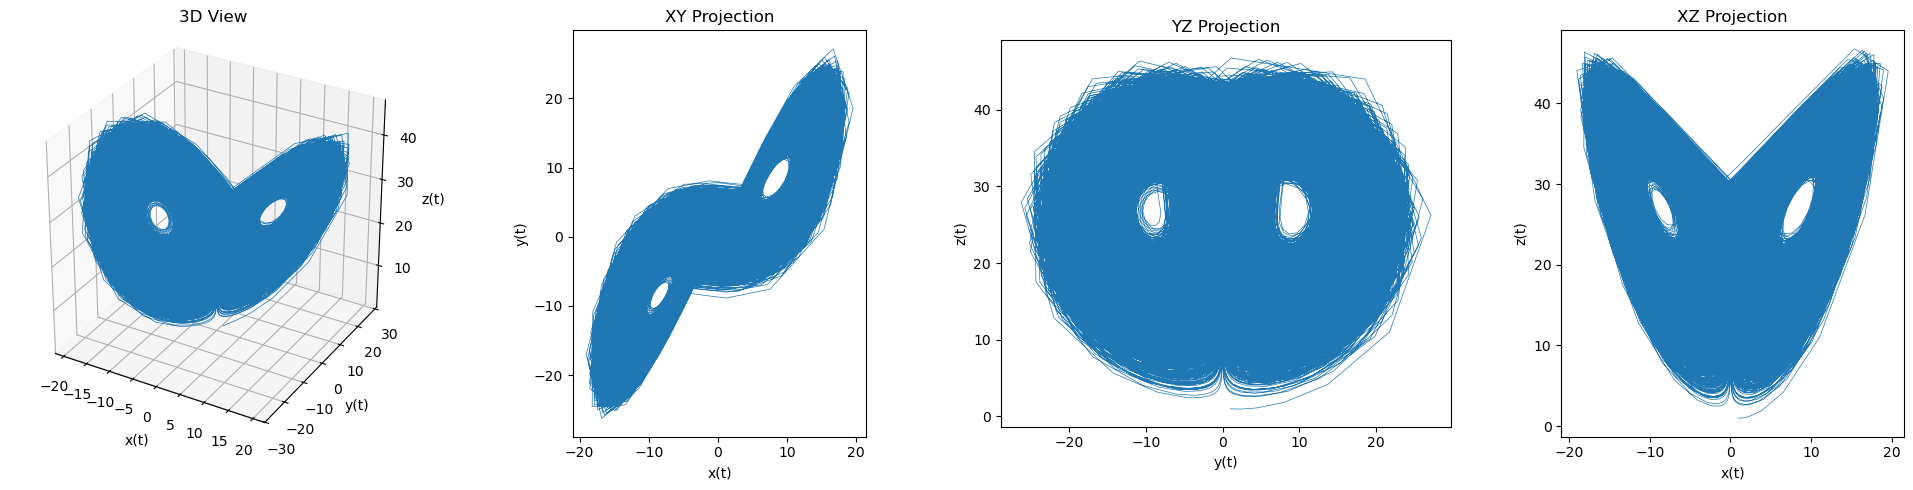

In [38]:
# Subsample trajectory to plot fewer points
thin = trajectory[::5]

fig = plt.figure(figsize=(20, 5))

# 3D
ax0 = fig.add_subplot(1, 4, 1, projection='3d')
ax0.plot(thin[:, 0], thin[:, 1], thin[:, 2], lw=0.5)
ax0.set_xlabel('x(t)'); ax0.set_ylabel('y(t)'); ax0.set_zlabel('z(t)')
ax0.set_title('3D View')
ax0.set_box_aspect((1,1,1))  # equal aspect in 3D

# XY
ax1 = fig.add_subplot(1, 4, 2)
ax1.plot(thin[:, 0], thin[:, 1], lw=0.5)
ax1.set_xlabel('x(t)'); ax1.set_ylabel('y(t)')
ax1.set_title('XY Projection')
ax1.set_aspect('equal', 'box')

# YZ
ax2 = fig.add_subplot(1, 4, 3)
ax2.plot(thin[:, 1], thin[:, 2], lw=0.5)
ax2.set_xlabel('y(t)'); ax2.set_ylabel('z(t)')
ax2.set_title('YZ Projection')
ax2.set_aspect('equal', 'box')

# XZ
ax3 = fig.add_subplot(1, 4, 4)
ax3.plot(thin[:, 0], thin[:, 2], lw=0.5)
ax3.set_xlabel('x(t)'); ax3.set_ylabel('z(t)')
ax3.set_title('XZ Projection')
ax3.set_aspect('equal', 'box')

plt.tight_layout()

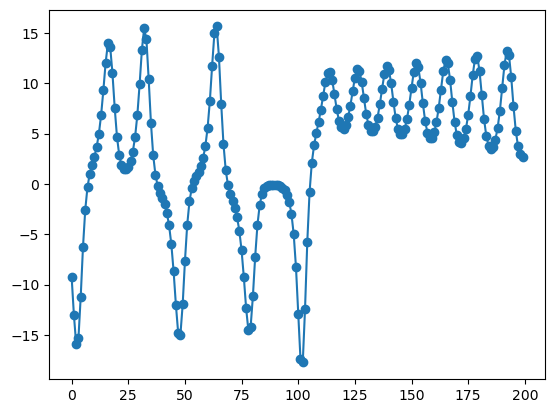

In [39]:
plt.plot(trajectory[-1000::5,0], 'o-')

In [40]:
print("First point of full trajectory:", trajectory[0])
print("Second point of full trajectory:", trajectory[1])
print("Third point of full trajectory:", trajectory[2])


First point of full trajectory: [1. 1. 1.]
Second point of full trajectory: [1.01256719 1.2599178  0.98489097]
Third point of full trajectory: [1.04882371 1.52399713 0.97311422]


# Feed Forward Neural Network

In [41]:
def make_windows_with_stride(traj, lags, horizon=1):
    X, y = [], []
    max_lag = max(lags)
    N = len(traj)
    for i in range(N - max_lag - horizon):
        window = [traj[i + lag] for lag in lags]           
        X.append(np.concatenate(window))                   
        y.append(traj[i + max_lag + horizon])              
    return np.array(X), np.array(y)

# Neural Network Class

In [42]:
class NeuralNetwork:
    def __init__(self, input_size = 64, hidden_size = 30, output_size = 10, learning_rate = 1e-3, epochs = 1000):
        # Hyperparameters
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        # Weights & bias initialization with small random values
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01  
        self.b1 = np.zeros((1, hidden_size))                       
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01 
        self.b2 = np.zeros((1, output_size))                       #

    # ReLU activation function
    def ReLU(self, x):
        return np.maximum(0, x)

    # Derivative of the ReLU function
    def ReLU_deriv(self, x):
        return np.where(x > 0, 1, 0)

    # Linear Activation Function
    def Linear(self, x):
        return x

    def Linear_deriv(self, x):
        return np.ones_like(x)

    # Forward propagation: computes the activations for the hidden and output layers
    def forward_propagation(self, x):
        # Hidden layer
        self.z1 = x @ self.W1 + self.b1
        self.a1 = self.ReLU(self.z1)
    
        # Output layer
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.Linear(self.z2)
        
        return self.a2

    # Compute the cost using Mean Squared Error
    def compute_cost(self, y_pred, y_true):
        return np.mean((y_pred - y_true)**2)

    # Back propagation: computes gradients for updating weights and biases
    def back_propagation(self, x, y):       
        m = y.shape[0]
    
        # Compute error at output layer
        error2 = 2 * (self.a2 - y) * self.Linear_deriv(self.z2)

        # Compute gradients for weights and biases for the output layer
        grad_W2 = (self.a1.T @ error2) / m
        grad_b2 = np.sum(error2, axis = 0, keepdims = True) / m

        # Backpropagate the error to the hidden layer
        error1 = (error2 @ self.W2.T) * self.ReLU_deriv(self.z1)

        # Compute gradients for weights and biases for the hidden layer
        grad_W1 = (x.T @ error1) / m
        grad_b1 = np.sum(error1, axis = 0, keepdims = True) / m

        return grad_W1, grad_b1, grad_W2, grad_b2

    # Update the network parameters (weights and biases) using the computed gradients
    def update_parameters(self, grad_W1, grad_b1, grad_W2, grad_b2):
        self.W2 = self.W2 - (self.learning_rate * grad_W2)
        self.b2 = self.b2 - (self.learning_rate * grad_b2)
        self.W1 = self.W1 - (self.learning_rate * grad_W1)
        self.b1 = self.b1 - (self.learning_rate * grad_b1)

    # Train the neural network by iterating over epochs
    def train(self, x, y, optimizer='sgd'):
        optimizer = optimizer.lower()
        
        if optimizer not in ('sgd', 'adam'):
            raise ValueError("Optimizer must be 'sgd' or 'adam'")

        # Adam hyperparameters
        if optimizer == 'adam':
            beta1, beta2 = 0.9, 0.999
            eps = 1e-8
            # Initialize 1st & 2nd moment vectors
            m_W1 = np.zeros_like(self.W1); v_W1 = np.zeros_like(self.W1)
            m_b1 = np.zeros_like(self.b1); v_b1 = np.zeros_like(self.b1)
            m_W2 = np.zeros_like(self.W2); v_W2 = np.zeros_like(self.W2)
            m_b2 = np.zeros_like(self.b2); v_b2 = np.zeros_like(self.b2)

        for epoch in range(1, self.epochs + 1):
            # Perform forward propagation to get outputs
            Y_pred = self.forward_propagation(x)

            # Compute gradients via back propagation
            grad_W1, grad_b1, grad_W2, grad_b2 = self.back_propagation(x, y)

            if optimizer == 'sgd':
                # Update network parameters with the gradients using Standard SGD
                self.update_parameters(grad_W1, grad_b1, grad_W2, grad_b2)

            else:
                # Adam updates
                m_W1 = beta1 * m_W1 + (1 - beta1) * grad_W1
                v_W1 = beta2 * v_W1 + (1 - beta2) * (grad_W1 ** 2)
                m_b1 = beta1 * m_b1 + (1 - beta1) * grad_b1
                v_b1 = beta2 * v_b1 + (1 - beta2) * (grad_b1 ** 2)
                m_W2 = beta1 * m_W2 + (1 - beta1) * grad_W2
                v_W2 = beta2 * v_W2 + (1 - beta2) * (grad_W2 ** 2)
                m_b2 = beta1 * m_b2 + (1 - beta1) * grad_b2
                v_b2 = beta2 * v_b2 + (1 - beta2) * (grad_b2 ** 2)

                # Bias-corrected moments
                mW1_hat = m_W1 / (1 - beta1 ** epoch)
                vW1_hat = v_W1 / (1 - beta2 ** epoch)
                mb1_hat = m_b1 / (1 - beta1 ** epoch)
                vb1_hat = v_b1 / (1 - beta2 ** epoch)
                mW2_hat = m_W2 / (1 - beta1 ** epoch)
                vW2_hat = v_W2 / (1 - beta2 ** epoch)
                mb2_hat = m_b2 / (1 - beta1 ** epoch)
                vb2_hat = v_b2 / (1 - beta2 ** epoch)

                # Update parameters
                self.W1 -= self.learning_rate * mW1_hat / (np.sqrt(vW1_hat) + eps)
                self.b1 -= self.learning_rate * mb1_hat / (np.sqrt(vb1_hat) + eps)
                self.W2 -= self.learning_rate * mW2_hat / (np.sqrt(vW2_hat) + eps)
                self.b2 -= self.learning_rate * mb2_hat / (np.sqrt(vb2_hat) + eps)

            # Every 100 epochs, compute and print the cost for monitoring convergence
            if (epoch%100 == 0):
                cost = self.compute_cost(Y_pred, y)
                print(f"Epoch {epoch}, Cost: {cost:.6f}, Optimizer: {optimizer.upper()}")

    # Predict class labels for input data
    def predict(self, x):
        return self.forward_propagation(x)

# Training the Neural Network

In [43]:
window_size = 20
horizon     = 1
lags = [0, 5, 9]

X, y = make_windows_with_stride(trajectory, lags, 4)

### Splitting into Training, Validation, and Test Set

In [11]:
n = X.shape[0]
n_train = int(0.70*n)
n_val   = int(0.15*n)

X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:], y[n_train+n_val:]

In [12]:
print(f"Total points: {N}")
print(f"  Training : {X_train.shape[0]} samples")
print(f"  Validation: {X_val.shape[0]} samples")
print(f"  Testing  : {X_test.shape[0]} samples")

Total points: 500000
  Training : 349986 samples
  Validation: 74997 samples
  Testing  : 74998 samples


### Normalizing the Data Points

In [13]:
eps = 1e-8   # Added to standard deviation values to avoid division by zero error
Xmu,  Xstd  = X_train.mean(0, keepdims=True), X_train.std(0, keepdims=True) + eps
ymu,  ystd  = y_train.mean(0, keepdims=True), y_train.std(0, keepdims=True) + eps

X_train = (X_train - Xmu)/Xstd
X_val   = (X_val   - Xmu)/Xstd
X_test  = (X_test  - Xmu)/Xstd

y_train = (y_train - ymu)/ystd
y_val   = (y_val   - ymu)/ystd
y_test  = (y_test  - ymu)/ystd

In [15]:
model = NeuralNetwork(
    input_size    = window_size * 3,
    hidden_size   = 30,
    output_size   = horizon * 3,
    learning_rate = 1e-3,
    epochs        = 1000 
)

model.train(X_train, y_train)

Epoch 100, Cost: 0.984794, Optimizer: SGD
Epoch 200, Cost: 0.930140, Optimizer: SGD
Epoch 300, Cost: 0.755238, Optimizer: SGD
Epoch 400, Cost: 0.489367, Optimizer: SGD
Epoch 500, Cost: 0.360407, Optimizer: SGD
Epoch 600, Cost: 0.304687, Optimizer: SGD
Epoch 700, Cost: 0.250497, Optimizer: SGD
Epoch 800, Cost: 0.191859, Optimizer: SGD
Epoch 900, Cost: 0.138167, Optimizer: SGD
Epoch 1000, Cost: 0.097925, Optimizer: SGD


In [16]:
y_hat_val = model.predict(X_val)*ystd + ymu
mse_val   = np.mean((y_hat_val - (y_val*ystd + ymu))**2)
print("Validation MSE:", mse_val)

Validation MSE: 7.550538164499468


Typical x, y, z values on the attractor are roughly in the range [-20, 40]. RMSE = sqrt(MSE) = 2.55. So, on average, each coordinate is off by ≈ 2.5 units one time-step (Δt=0.01) into the future.

# Hyperparameter Tuning

In [17]:
# param_grid = {
#     'window_size':  [10, 20, 50],
#     'hidden_size':  [30,  50, 100],
#     'learning_rate':[1e-3,1e-2],
#     'batch_size':   [32,  64],
#     'optimizer':    ['sgd','adam'],
#     'epochs':       [100, 500, 1000]
# }

# best_mse    = float('inf')
# best_params = None
# best_model  = None
# best_hist   = None

In [18]:
# for combo in itertools.product(*param_grid.values()):
#     params = dict(zip(param_grid.keys(), combo))
#     X_train_w, y_train_w = make_windows(trajectory[:n_train], params['window_size'])
#     X_val_w, y_val_w   = make_windows(trajectory[n_train:n_train+n_val], params['window_size'])

#     model = NeuralNetwork(
#         input_size    = params['window_size'] * 3,
#         hidden_size   = params['hidden_size'],
#         output_size   = 3,                     
#         learning_rate = params['learning_rate'],
#         epochs        = params['epochs']
#     )
    
#     history = model.train(
#         X_train_w, y_train_w,
#         optimizer = params['optimizer'],
#     )

#     val_pred = model.predict(X_val_w)
#     val_mse  = np.mean((val_pred - y_val_w)**2)

#     print(f"Params={params}  →  Val MSE={val_mse:.4e}")
    
#     if val_mse < best_mse:
#         best_mse    = val_mse
#         best_params = params
#         best_model  = deepcopy(model)
#         best_hist   = history

# print("\nBest params:", best_params)
# print("Best validation MSE:", best_mse)

In [19]:
best_params = {'window_size': 20, 'hidden_size': 100, 'learning_rate': 0.01, 'batch_size': 64, 'optimizer': 'adam', 'epochs': 1000}

In [20]:
print("\nBest params:", best_params)


Best params: {'window_size': 20, 'hidden_size': 100, 'learning_rate': 0.01, 'batch_size': 64, 'optimizer': 'adam', 'epochs': 1000}


In [44]:
X_trainval, y_trainval = make_windows(trajectory[:n_train+n_val], lags, 4)
X_test_w,   y_test_w   = make_windows(trajectory[n_train+n_val:], lags, 4)

X_trainval = (X_trainval - Xmu) / Xstd
y_trainval = (y_trainval - ymu) / ystd

X_test_w = (X_test_w - Xmu) / Xstd
y_test_w = (y_test_w - ymu) / ystd

final_model = NeuralNetwork(
    input_size  = best_params['window_size'] * 3,
    hidden_size = best_params['hidden_size'],
    learning_rate = best_params['learning_rate'],
    epochs      = best_params['epochs'],
    output_size = 3
)

final_hist = final_model.train(
    X_trainval, y_trainval,
    optimizer   = best_params['optimizer']    
)

TypeError: unsupported operand type(s) for -: 'int' and 'list'

In [ ]:
test_pred = final_model.predict(X_test_w)
test_mse  = np.mean((test_pred - y_test_w)**2)
print("Test MSE:", test_mse)

RMSE = 0.074. So, on average, each coorainet is off by ~0.07 units just one time-step (Δt = 0.01) into the future. It captures the immediate local dynamics of a chaotic system with less than a tenth of a unit error

In [ ]:
# # Capture the printed training output into a string buffer
# buffer = io.StringIO()
# old_stdout = sys.stdout
# sys.stdout = buffer

# # Retrain on your best model (this will still print, but now into `buffer`)
# final_model.train(X_trainval, y_trainval, optimizer=best_params['optimizer'])

# sys.stdout = old_stdout

# # Extract epoch & cost from the captured log
# log_lines = buffer.getvalue().splitlines()
# epochs, losses = [], []
# for line in log_lines:
#     m = re.match(r"Epoch\s+(\d+), Cost:\s*([\d\.eE+-]+)", line)
#     if m:
#         epochs.append(int(m.group(1)))
#         losses.append(float(m.group(2)))

In [ ]:
# plt.figure(figsize=(8,4))
# plt.plot(epochs, losses, marker='o', label='Train Loss')
# plt.title("Train Loss (best model retrained)")
# plt.xlabel("Epoch")
# plt.ylabel("MSE")
# plt.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
# ---- parameters ----
window_size = best_params['window_size']
n_forecast  = 1000
horizon     = 5
dim         = 3

# 1) Rebuild windows to locate test start
X_all, y_all = make_windows(trajectory, window_size, horizon)
n            = X_all.shape[0]
n_train      = int(0.70 * n)
n_val        = int(0.15 * n)
test_start   = n_train + n_val   # index in X_all where X_test begins

# 2) Grab the window that *ends* right before your test set
#    In trajectory coordinates, that window starts at `test_start` and spans window_size points
L0     = test_start
window = trajectory[L0 : L0 + window_size].copy()   # shape (window_size, 3)

# 3) Closed‐loop forecast
forecast = np.zeros((n_forecast, dim))
for t in range(n_forecast):
    # normalize, predict, denormalize
    x_norm = (window.flatten()[None, :] - Xmu) / Xstd    # shape (1, window_size*3)
    y_norm = final_model.predict(x_norm)                 # shape (1,3)
    y      = (y_norm * ystd + ymu).flatten()
    forecast[t] = y
    # slide the window
    window = np.vstack([window[1:], y])

# 4) Extract the true past & true future in the x‐coordinate
true_past   = trajectory[L0 : L0 + window_size,        0]  # x at t = L0 … L0+window_size–1
true_future = trajectory[L0 + window_size : L0 + window_size + n_forecast, 0]
forecast_x  = forecast[:, 0]

# time axes
t_past = np.arange(-window_size, 0)     # [-window_size … -1]
t_fut  = np.arange(0, n_forecast)       # [0 … n_forecast-1]

# --- Plot 1: true past → true future continuity ---
plt.figure(figsize=(8,4))
plt.plot( t_past, true_past,   'o-', label=f"True past ({window_size})" )
plt.plot(    t_fut, true_future,  '-', label="True future", alpha=0.6 )
plt.axvline(0, color='k', linestyle='--', lw=1)
plt.xlabel("Relative time step")
plt.ylabel("x coordinate")
plt.title("True Lorenz: past → future")
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot 2: model forecast vs true continuation ---
plt.figure(figsize=(8,4))
plt.plot(    t_fut, true_future, label="True future", alpha=0.6 )
plt.plot(    t_fut, forecast_x, '--', label="Forecast",    alpha=0.8 )
plt.xlabel("Relative time step")
plt.ylabel("x coordinate")
plt.title("Closed‐loop Forecast vs. True continuation")
plt.legend()
plt.tight_layout()
plt.show()
